# import

In [21]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import pingouin as pg
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_1samp
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from collections import defaultdict

def manova_groups_neuron_involvement(data1,data2):

    nrem_means = []
    for key in data1:
        if len(data1[key]) > 0:
            nrem_means += [np.nanmean(data1[key])]
    rem_means = []       
    for key in data2:
        if len(data2[key]) > 0:
            rem_means += [np.nanmean(data2[key])]

    x = nrem_means
    y = sorted(data1)

    x2 = rem_means
    y2 = sorted(data2)

    import statsmodels.api as sm
    from statsmodels.multivariate.manova import MANOVA

    A = pd.DataFrame({'x': x,
                    'y': y,
                    'groups': ['A'] * len(x)})
    B = pd.DataFrame({'x': x2,
                    'y': y2,
                    'groups': ['B'] * len(x2)})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)


    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    print(manova.mv_test())
    
    return manova.mv_test()
    

def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship


def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):

    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_, markersize = 10)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')


def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = '#69BD45',alpha = 0.4)
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = '#32495C',alpha = 0.4)
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    
def cohens_d(x, y):
    """
    Compute Cohen's d for two independent samples.
    """
    x = np.array(x)
    y = np.array(y)
    nx = len(x)
    ny = len(y)
    # Pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx + ny - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

def permutation_test(list1, list2):
    # Define your test statistic function
    def test_statistic(list1, list2):
        return np.mean(list1) - np.mean(list2)

    # Compute the observed test statistic
    observed_statistic = test_statistic(list1, list2)

    # Combine the two lists
    combined_data = list1 + list2

    # Number of permutations
    num_permutations = 100000

    # Initialize an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Permutation test
    for i in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two lists
        permuted_list1 = combined_data[:len(list1)]
        permuted_list2 = combined_data[len(list1):]
        
        # Compute the test statistic for the permuted data
        permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

    # Calculate the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)


    plt.figure(figsize=(4, 3))
    plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of Permuted Test Statistics')
    plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
    plt.xlabel('Test Statistic')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    print("- p-value:", p_value)
    print('- 99th percentile of permuted statistics:',np.percentile(permuted_statistics, 99))
    print("- Observed Test Statistic:", observed_statistic)
    
def permanova_ordered_misordered(nrem, rem):

    df = pd.DataFrame(nrem + rem, columns=['ordered','misordered'])
    df['group'] = ['nrem']*len(nrem) + ['rem']*len(rem)

    # drop any NaNs
    df = df.dropna()

    # compute distance matrix
    dm = DistanceMatrix(
        squareform(pdist(df[['ordered','misordered']].values, 'euclidean'))
    )

    # run PERMANOVA
    res = permanova(dm, grouping=df['group'].tolist(), permutations=999)
    print(res)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(df['group'].tolist())
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(df['group'].tolist())
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")


# ------------------------------------------------------------
def collapse(freqs, cap=6):
    # force presence of all bins
    out = {str(i): [] for i in range(1, cap + 1)}

    for k, v in freqs.items():
        kk = str(cap if int(k) >= cap else int(k))
        out[kk].extend(v)

    return out


# ------------------------------------------------------------
def plot_group(ax, counts, keys, x_offset, color, stat_fn):
    for k in keys:
        y = counts[k]
        if len(y) == 0:
            continue

        if sum(y) == 0:
            continue
        x = float(k) + x_offset
        ax.plot(np.full(len(y), x), y, 'o',
                c=color, alpha=0.5, ms=9, mew=0)
        ax.plot(x, stat_fn(y), '<',
                c=color, alpha=0.8, ms=9, mew=0)


# ------------------------------------------------------------
def permanova_coactive_freqs(dat1, dat2, cap=6):
    keys = [str(i) for i in range(1, cap + 1)]

    n1 = len(dat1['1'])
    n2 = len(dat2['1'])

    df = pd.DataFrame()
    df['groups'] = ['control'] * n1 + ['lesion'] * n2

    for k in keys:
        v1 = dat1.get(k, []).copy()
        v2 = dat2.get(k, []).copy()

        v1 += [0] * (n1 - len(v1))
        v2 += [0] * (n2 - len(v2))

        df[k] = v1 + v2

    values = df[keys].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    dm = DistanceMatrix(squareform(pairwise_distances))

    results = permanova(dm, grouping, permutations=10000)
    print(results)

    # --------------------------------------------------------
    # Effect size R² (distance-based)
    # --------------------------------------------------------
    D = dm.data
    n = len(grouping)
    ss_total = np.sum(D ** 2) / n

    ss_between = 0
    for g in np.unique(grouping):
        idx = np.where(grouping == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
def permanova_coactive_freqs(dat1, dat2):
    df = pd.DataFrame()
    df['groups'] = ['control']*len(dat1[1])  + ['lesion']*len(dat2[1])

    for key in [1,2,3,4,5,6]:
        if key not in dat1:
            dat1[key] = [0]
        if key not in dat2:
            dat2[key] = [0]
        current_var = dat1[key]
        while len(current_var)<len(dat1[1]):
            current_var +=[0]
        
        try:
            dat2[key]
            current_var_l = dat2[key]
            while len(current_var_l)<len(dat2[1]):
                current_var_l +=[0]
        except:
            current_var_l = [0]*len(dat2[1])
            
            
        df[str(key)] = current_var + current_var_l
        

    # Calculate the Euclidean distance matrix
    values = df[['1', '2', '3', '4', '5', '6']].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")




def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends
    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)
    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)
    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)
    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)
    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)
    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)
        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')
    ax2.set_xlim(0,100)

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict

def plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(7, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(nrem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(nrem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(rem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(rem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}
    return group1_data, group2_data

def pairwise_permanova_by_feature(data, group_labels, method='bonferroni', permutations=10000):
    """
    Perform pairwise PERMANOVA on each feature column, correcting p-values
    across all feature×pairwise tests. For any pair where the feature is
    constant, record statistic=0, p_value=1 instead of running PERMANOVA.
    Returns a list of dicts:
      feature, group1, group2, test_stat, p_value, permutations
    """
    unique_groups = np.unique(group_labels)
    pairwise_combinations = list(combinations(unique_groups, 2))

    results = []
    all_pvals = []

    n_features = data.shape[1]

    for feat_idx in range(n_features):
        feat = data[:, feat_idx]

        for g1, g2 in pairwise_combinations:
            mask = np.isin(group_labels, [g1, g2])
            sub_feat = feat[mask]
            sub_labels = group_labels[mask]

            # If the feature is constant across these two groups, skip PERMANOVA:
            if np.unique(sub_feat).size == 1:
                stat, pval = 0.0, 1.0
                r2 = 0
            else:
                # Compute distances and run PERMANOVA
                dist_mat = squareform(pdist(sub_feat[:, None], metric='euclidean'))
                dist_mat = np.ascontiguousarray(dist_mat)
                ids = [str(i) for i in range(len(sub_labels))]
                dm = DistanceMatrix(dist_mat, ids)
                res = permanova(dm, sub_labels, permutations=permutations)
                stat, pval = res["test statistic"], res["p-value"]
                
                #Compute R² manually (effect size)
                # ss_total = sum of squared distances / n
                D = dm.data        # <-- this is the fix
                n = len(sub_labels)
                ss_total = np.sum(D**2) / n

                # ss_between: sum of squared group means
                group_labels = np.array(sub_labels)
                unique_groups = np.unique(group_labels)
                ss_between = 0
                for g in unique_groups:
                    idx = np.where(group_labels == g)[0]
                    Di = D[np.ix_(idx, idx)]
                    ss_between += len(idx) * (Di.mean() ** 2)

                r2 = ss_between / ss_total

            results.append({
                "feature": feat_idx,
                "group1": g1,
                "group2": g2,
                "test_stat": stat,
                "p_value": pval,
                "permutations": permutations,
                "R2": r2
            })
            all_pvals.append(pval)

    # Multiple testing correction
    corrected = multipletests(all_pvals, method=method)[1]
    for i, cp in enumerate(corrected):
        results[i]["p_value"] = cp
        
    return results


def group_difference_permanova(f_warp_factors, r_warp_factors, learning_f_warp_factors, learning_r_warp_factors):

    # grouping = ['control_forwards']*len(np.vstack(e_f_warp_factors)) + ['control_reverse']*len(np.vstack(e_r_warp_factors)) + ['lesion_forwards']*len(np.vstack(hl_f_warp_factors)) + ['lesion_reverse']*len(np.vstack(hl_r_warp_factors))
    grouping = ['control']*len(np.vstack(f_warp_factors)) + ['control']*len(np.vstack(r_warp_factors)) + ['test']*len(np.vstack(learning_f_warp_factors)) + ['test']*len(np.vstack(learning_r_warp_factors))
    # data is stacked so that each row is a sample (animal) and each colum is a variable/test

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors+learning_f_warp_factors+learning_r_warp_factors), metric='euclidean')

    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
    return grouping


# PERMANOVA forward vs reverse diff
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

def permanova_forward_vs_reverse(f_warp_factors, r_warp_factors):
    grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    

def effect_size(x=None, y=None, test='ttest', dv=None, between=None, data=None,
                dm=None, grouping=None, popmean=None, permutations=999):
    """
    Calculate effect sizes for parametric, non-parametric, regression, and PERMANOVA.

    Parameters
    ----------
    x : array-like
        First sample (or single sample for one-sample t-test)
    y : array-like, optional
        Second sample (if applicable)
    test : str
        One of ['ttest', 'paired_ttest', 'one_sample_ttest', 'anova',
                'mannwhitney', 'wilcoxon', 'kruskal', 'correlation', 'permanova']
    dv, between, data : for ANOVA/Kruskal (pingouin syntax)
    dm : DistanceMatrix for PERMANOVA
    grouping : array-like of group labels for PERMANOVA
    popmean : population mean for one-sample t-test
    permutations : number of permutations for PERMANOVA
    """
    # Convert to numpy arrays if needed
    x = np.array(x) if x is not None else None
    y = np.array(y) if y is not None else None

    if test == 'ttest':  # independent
        t, p = stats.ttest_ind(x, y)
        pooled_std = np.sqrt(((len(x)-1)*x.std(ddof=1)**2 + (len(y)-1)*y.std(ddof=1)**2) / (len(x)+len(y)-2))
        d = (x.mean() - y.mean()) / pooled_std
        return {"cohens_d": d}

    elif test == 'paired_ttest':
        t, p = stats.ttest_rel(x, y)
        d = (x - y).mean() / (x - y).std(ddof=1)
        return {"cohens_d": d}

    elif test == 'one_sample_ttest':
        if popmean is None:
            raise ValueError("popmean must be provided for one-sample t-test")
        t, p = stats.ttest_1samp(x, popmean)
        d = (np.nanmean(x) - popmean) / x.std(ddof=1)
        return {"cohens_d": d}

    elif test == 'anova':
        res = pg.anova(dv=dv, between=between, data=data, detailed=True)
        return res[['Source', 'F', 'p-unc', 'eta-square', 'partial_eta-square']]

    elif test == 'mannwhitney':
        res = pg.mwu(x, y, alternative='two-sided', effsize='r')
        return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'wilcoxon':
        res = pg.wilcoxon(x, y, alternative='two-sided')
        return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'kruskal':
        res = pg.kruskal(data=data, dv=dv, between=between)
        return res[['H', 'p-unc', 'eta-square', 'eps-square']]

    elif test == 'correlation':
        r, p = stats.pearsonr(x, y)
        return {"test": "Pearson correlation", "r": r, "p": p}

    else:
        raise ValueError(f"Unsupported test type: {test}")
    
import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels

def extract_mean_warps(regression_df, bins_,animals_list):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse in animals_list:
        mask = regression_df.mouse == mouse
        group = regression_df[mask]
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]


            
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

# figure A

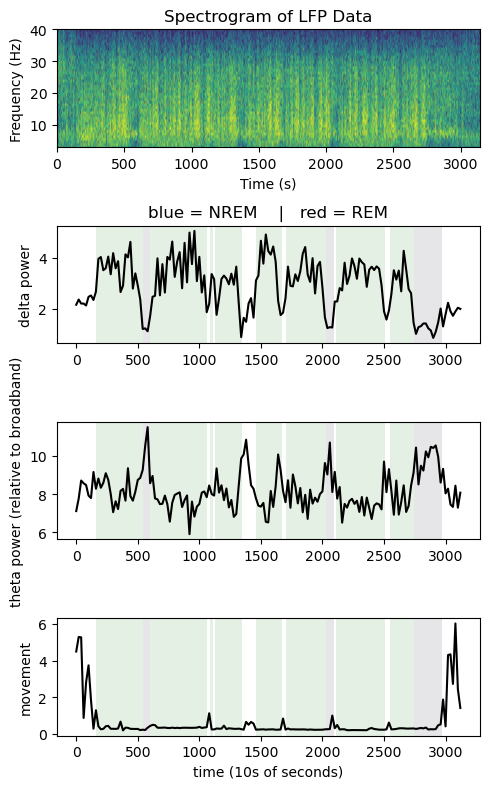

In [2]:

data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED7\lfp_sleep_figure_data_v2.npz", allow_pickle=True)

log_power = data["log_power"]
frequencies = data["frequencies"]
times = data["times"]

t_points_cut = data["t_points_cut"]
delta_cut = data["delta_cut"]
theta_r_cut = data["theta_r_cut"]
average_velocity_cut = data["average_velocity_cut"]

nrem_spans = data["nrem_spans"].tolist()
rem_spans = data["rem_spans"].tolist()

spectrogram_params = data["spectrogram_params"].item()
span_params = data["span_params"].item()


# =========================
# Helper: sleep shading
# =========================
def shade_spans(axs, spans, color, bin_width=1, alpha=0.2):
    for span in spans:
        if isinstance(span, (list, tuple, np.ndarray)):
            start, end = span
        else:
            start = span - 0.5
            end = span + 0.5

        x0 = start * bin_width
        x1 = end * bin_width

        for ax in axs:
            ax.axvspan(x0, x1, facecolor=color, alpha=alpha)

# =========================
# Figure
# =========================
fig, [ax, ax1, ax2, ax3] = plt.subplots(4, 1, figsize=(5, 8))

# --- Spectrogram ---
im = ax.imshow(
    log_power,
    aspect="auto",
    origin="lower",
    cmap=spectrogram_params["cmap"],
    extent=[
        0,
        times.max(),
        frequencies.min(),
        frequencies.max()
    ],
    vmin=spectrogram_params["vmin"],
    vmax=spectrogram_params["vmax"]
)

ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (s)")
ax.set_title("Spectrogram of LFP Data")
ax.set_ylim(*spectrogram_params["freq_ylim"])

# --- Delta ---
ax1.plot(
    t_points_cut,
    delta_cut / np.std(delta_cut),
    c="k"
)
ax1.set_title("blue = NREM    |   red = REM")
ax1.set_ylabel("delta power")

# --- Theta ratio ---
ax2.plot(
    t_points_cut,
    theta_r_cut / np.std(theta_r_cut),
    c="k"
)
ax2.set_ylabel("theta power (relative to broadband)")

# --- Movement ---
ax3.plot(
    t_points_cut,
    average_velocity_cut / np.std(average_velocity_cut),
    c="k"
)
ax3.set_xlabel("time (10s of seconds)")
ax3.set_ylabel("movement")

# --- Sleep state shading ---
axs = [ax1, ax2, ax3]

shade_spans(
    axs,
    nrem_spans,
    color=span_params["nrem_color"],
    bin_width=span_params["bin_width"],
    alpha=span_params["alpha"]
)

shade_spans(
    axs,
    rem_spans,
    color=span_params["rem_color"],
    bin_width=span_params["bin_width"],
    alpha=span_params["alpha"]
)

plt.tight_layout()
plt.show()


# figure B

In [3]:
#Load the pickled files

in_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\plotting_data\\"

# dump to pickle
with open(in_path + "NREM_REM_processed_replay_data.pkl", 'rb') as f:
    rem_nrem_master = pickle.load(f)
    
with open(in_path + "awake_seqbyseq_neuron_involvements.pkl", 'rb') as f:
    neuron_involvement_master = pickle.load(f)
    
    


ShapiroResult(statistic=np.float64(0.9497536861314816), pvalue=np.float64(0.3370135366926875))
ShapiroResult(statistic=np.float64(0.641425331586676), pvalue=np.float64(5.574341509215321e-06))
WilcoxonResult(statistic=np.float64(14.0), pvalue=np.float64(0.0001049041748046875))


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61112\3544978639.py:481: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


{'test': 'Wilcoxon signed-rank',
 'W': np.float64(14.0),
 'p': np.float64(0.0001049041748046875),
 'rank_biserial_r': np.float64(0.8787878787878789)}

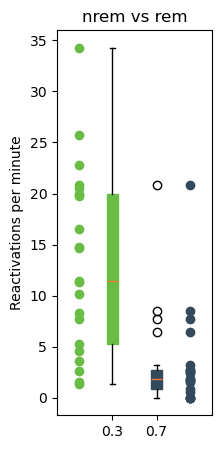

In [4]:
nrem_reactivations_per_min = rem_nrem_master['NREM']['reactivations_per_min']
rem_reactivations_per_min = rem_nrem_master['REM']['reactivations_per_min']

# replace nan values with 0
nrem_reactivations_per_min = [0 if np.isnan(item) else item for item in nrem_reactivations_per_min]
rem_reactivations_per_min = [0 if np.isnan(item) else item for item in rem_reactivations_per_min]

## PLOT
fig, ax = plt.subplots(figsize=(2, 5))
ax.plot(np.zeros(len(nrem_reactivations_per_min)), nrem_reactivations_per_min, 'o', color = '#69BD45')
ax.boxplot(nrem_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(rem_reactivations_per_min)), rem_reactivations_per_min, 'o', color = '#33495C')
ax.boxplot(rem_reactivations_per_min, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#33495C', color='#33495C'), medianprops=dict(color='#EE7832'))
ax.set_ylabel('Reactivations per minute')
ax.set_title('nrem vs rem')
## STATS
a = [x for x in nrem_reactivations_per_min if not np.isnan(x)]
b = [x for x in rem_reactivations_per_min if not np.isnan(x)]
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is not greater than 0.05 for both, so we reject the null hypothesis that the data is normally distributed
# non parametric t test, using scipy Wilcoxon Rank-Sum test
print(scipy.stats.wilcoxon(a, b))
effect_size(x=a, y=b, test='wilcoxon')

# figure C

ShapiroResult(statistic=np.float64(0.8583337126686227), pvalue=np.float64(0.0059320884637456125))
ShapiroResult(statistic=np.float64(0.8873925358867135), pvalue=np.float64(0.028942337079135627))
WilcoxonResult(statistic=np.float64(13.0), pvalue=np.float64(0.000335693359375))
{'test': 'Wilcoxon signed-rank', 'W': np.float64(13.0), 'p': np.float64(0.000335693359375), 'rank_biserial_r': np.float64(-0.8631578947368421)}


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61112\2489745248.py:4: RuntimeWarning: Mean of empty slice
  rem_event_lens = [np.nanmean(item) for item in rem_event_lens]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61112\3544978639.py:481: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


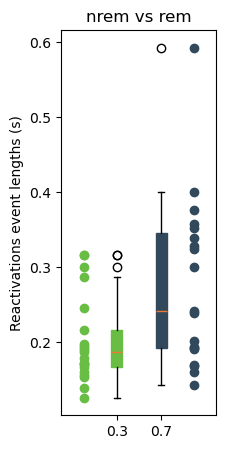

In [5]:
nrem_event_lens = rem_nrem_master['NREM']['event_lens']
rem_event_lens = rem_nrem_master['REM']['event_lens']
nrem_event_lens = [np.nanmean(item) for item in nrem_event_lens]
rem_event_lens = [np.nanmean(item) for item in rem_event_lens]

### PLOT
fig, ax = plt.subplots(figsize=(2, 5))
ax.plot(np.zeros(len(nrem_event_lens)), nrem_event_lens, 'o', color = '#69BD45')
ax.boxplot(nrem_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(rem_event_lens)), rem_event_lens, 'o', color = '#32495C')
ax.boxplot([x for x in rem_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_ylabel('Reactivations event lengths (s)')
ax.set_title('nrem vs rem')

### STATS
a = [x for x in nrem_event_lens if not np.isnan(x)]
b = [x for x in rem_event_lens if not np.isnan(x)]
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.wilcoxon(nrem_event_lens, rem_event_lens,nan_policy='omit'))
print(effect_size(x=nrem_event_lens, y=rem_event_lens, test='wilcoxon'))


# figure D

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61112\1788609537.py:7: RuntimeWarning: invalid value encountered in divide
  rem_proportion_forward_v_reverse = np.array(rem_forward_total)/np.array(rem_reverse_total)


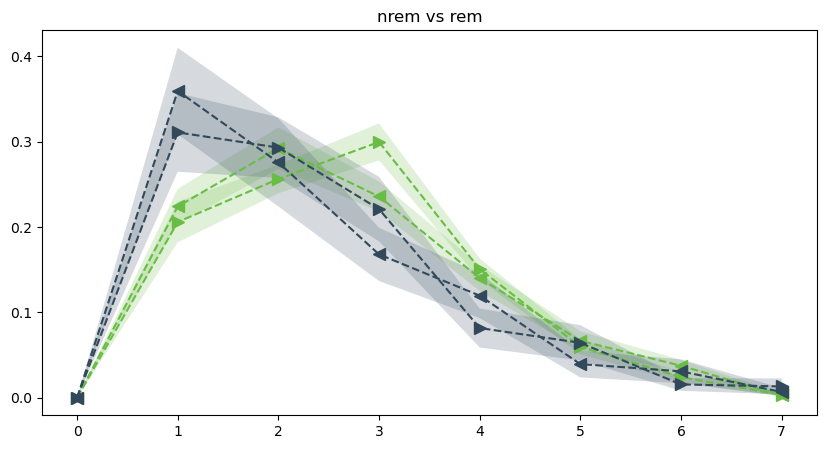

ShapiroResult(statistic=np.float64(0.8719594035128703), pvalue=np.float64(8.725500708879532e-11))
ShapiroResult(statistic=np.float64(0.8769455382335526), pvalue=np.float64(1.570390357101192e-10))
ShapiroResult(statistic=np.float64(0.7607403519055269), pvalue=np.float64(1.8345744418487906e-14))
ShapiroResult(statistic=np.float64(0.7197401190308279), pvalue=np.float64(1.0866055011493742e-15))
----------------------------
permanova - forward reverse
----------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic             1.829908
p-value                    0.135686
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.75207
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      38
number of groups                  2
test statistic             0.58

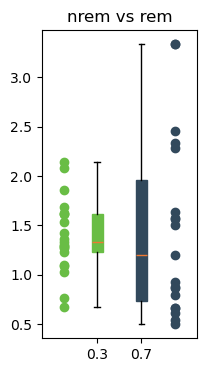

Inset: Difference from expected ------------------------
Test statistic: 4.842569309810121
P-value: 9.879016900263175e-05
{'cohens_d': np.float64(1.0567352581083302)}
--------------------
Test statistic: 2.1967803967615267
P-value: 0.041373113936092505
{'cohens_d': np.float64(0.5039759868755095)}
----------------------
Inset: comparison forward/reverse ------------------------
ShapiroResult(statistic=np.float64(0.9733893142536775), pvalue=np.float64(0.8063137657213336))
ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))
WilcoxonResult(statistic=np.float64(94.0), pvalue=np.float64(0.9843215942382812))
{'test': 'Wilcoxon signed-rank', 'W': np.float64(94.0), 'p': np.float64(0.9843215942382812), 'rank_biserial_r': np.float64(0.010526315789473717)}


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61112\3544978639.py:481: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


In [6]:
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]
animals_list = rem_nrem_master['NREM']['animals']

nrem_f_warp_factors, nrem_r_warp_factors, nrem_forward_total, nrem_reverse_total = extract_mean_warps(pd.DataFrame(rem_nrem_master['NREM']['regression']), bins_,animals_list)
nrem_proportion_forward_v_reverse = np.array(nrem_forward_total)/np.array(nrem_reverse_total)
rem_f_warp_factors, rem_r_warp_factors, rem_forward_total, rem_reverse_total = extract_mean_warps(pd.DataFrame(rem_nrem_master['REM']['regression']), bins_,animals_list)
rem_proportion_forward_v_reverse = np.array(rem_forward_total)/np.array(rem_reverse_total)

############################################################### PLOT 

fig,ax = plt.subplots(1, 1,figsize=(10, 5))
color_ = '#69BD45'
plot_warp_factors(ax, nrem_f_warp_factors, nrem_r_warp_factors, bins_, color_)
color_ = '#32495C'
plot_warp_factors(ax, rem_f_warp_factors, rem_r_warp_factors, bins_, color_)
ax.set_title('nrem vs rem')
plt.show()

## STATS

print(scipy.stats.shapiro([item for sublist in nrem_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in nrem_r_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in rem_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in rem_r_warp_factors for item in sublist]))
print('----------------------------')
print('permanova - forward reverse')
print('----------------------------')
permanova_forward_vs_reverse(nrem_f_warp_factors, nrem_r_warp_factors)
print('-------------------')
permanova_forward_vs_reverse(rem_f_warp_factors, rem_r_warp_factors)
print('----------------------------')
print('permanova - group differences')
print('----------------------------')
# PERMANOVA late vs early diff
el_grouping = group_difference_permanova(nrem_f_warp_factors, nrem_f_warp_factors, rem_f_warp_factors, rem_f_warp_factors)
print('----------------------------')
print('posthoc - group differences')
print('----------------------------')
# Combine:
combined_data = np.vstack([
    np.asarray(nrem_f_warp_factors),
    np.asarray(nrem_r_warp_factors),
    np.asarray(rem_f_warp_factors),
    np.asarray(rem_r_warp_factors)
])
combined_labels = np.array(el_grouping)
feature_results = pairwise_permanova_by_feature(
    combined_data,
    combined_labels,
    method='bonferroni',
    permutations=10000
)
print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
for res in feature_results:
    p = res["p_value"]
    if p < 0.05:
        stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
        print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
        print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}")
        print(f"R2 = {res['R2']}")
        print("---")


#### PLOT inset
fig, ax = plt.subplots(figsize=(2, 4))
ax.plot(np.zeros(len(nrem_proportion_forward_v_reverse)),nrem_proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in nrem_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(rem_proportion_forward_v_reverse)),rem_proportion_forward_v_reverse,'o', color = '#32495C')
ax.boxplot([x for x in rem_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_title('nrem vs rem')
plt.show()

### STATS for inset
print('Inset: Difference from expected ------------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(nrem_proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=nrem_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))

print('--------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(rem_proportion_forward_v_reverse, 1.0, nan_policy="omit")
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
rem_proportion_forward_v_reverse_nanr = rem_proportion_forward_v_reverse[~np.isnan(rem_proportion_forward_v_reverse)]
print(effect_size(x=rem_proportion_forward_v_reverse_nanr,test='one_sample_ttest',popmean = 1))

print('----------------------')
print('Inset: comparison forward/reverse ------------------------')
print(scipy.stats.shapiro(nrem_proportion_forward_v_reverse))
print(scipy.stats.shapiro(rem_proportion_forward_v_reverse))
# not all normal so use wilcoxn signed rank
print(scipy.stats.wilcoxon(nrem_proportion_forward_v_reverse, rem_proportion_forward_v_reverse,nan_policy='omit'))
print(effect_size(x=nrem_proportion_forward_v_reverse, y=rem_proportion_forward_v_reverse, test='wilcoxon'))

# figure E

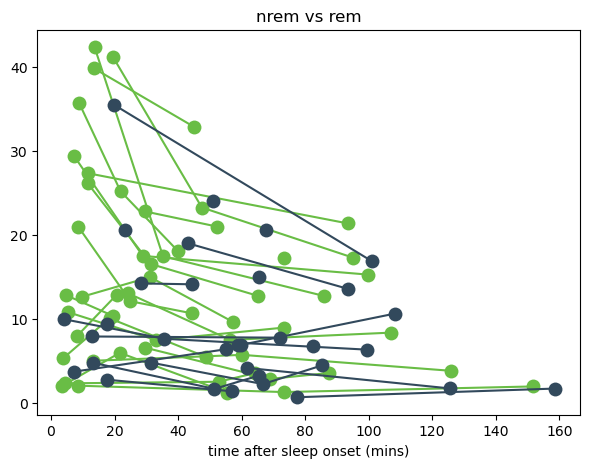

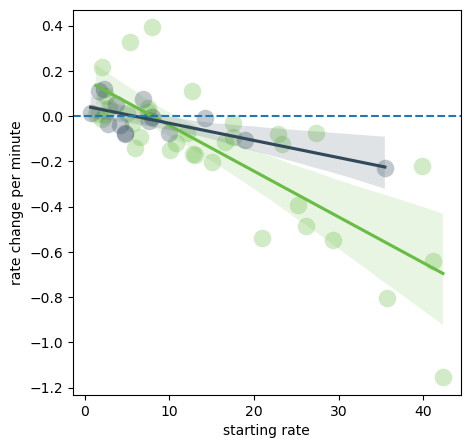

NameError: name 'df1' is not defined

In [7]:
import statsmodels.api as sm


group1_data, group2_data = plot_decay(rem_nrem_master['NREM']['binned_rate']  ,rem_nrem_master['NREM']['bins_relative_so'],rem_nrem_master['REM']['binned_rate']  ,rem_nrem_master['REM']['bins_relative_so'], '#69BD45','#32495C','nrem vs rem')
plt.show()
## STATS 
# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)
# Create a grouping variable
groups = np.array(['nrem'] * len(df1) + ['rem'] * len(df2))
# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)
# Print the MANOVA results
print(manova.mv_test())
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)

print('-----------------------------------------')
###################### STATS for inset
###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()
print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)
print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

# figure F

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


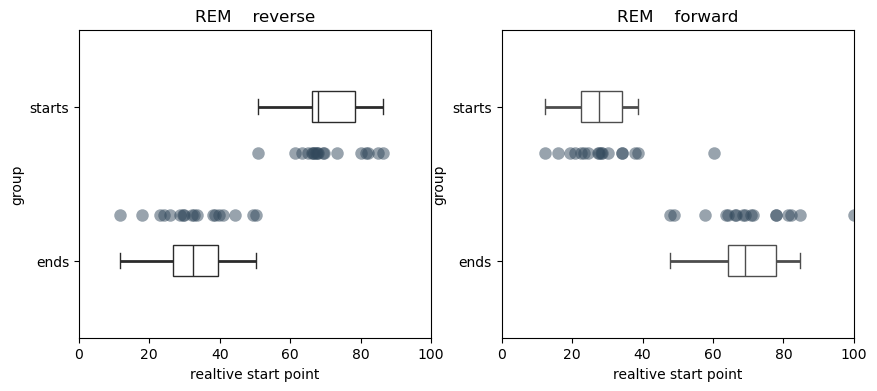

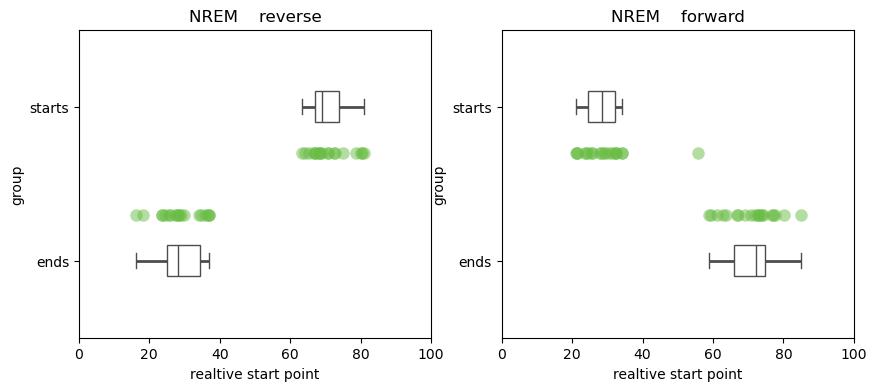

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ShapiroResult(statistic=np.float64(0.9061204963700601), pvalue=np.float64(0.06285938732751824))
ShapiroResult(statistic=np.float64(0.7736133615165437), pvalue=np.float64(0.0003582852080769677))
ShapiroResult(statistic=np.float64(0.9404969955492942), pvalue=np.float64(0.2691817853001265))
ShapiroResult(statistic=np.float64(0.9707792654946212), pvalue=np.float64(0.7712439799067917))
ShapiroResult(statistic=np.float64(0.9231248273603834), pvalue=np.float64(0.14683922611035938))
ShapiroResult(statistic=np.float64(0.9009760664365007), pvalue=np.float64(0.07052671673829441))
ShapiroResult(statistic=np.float64(0.9834605233155895), pvalue=np.float64(0.9785789173811841))
ShapiroResult(statistic=np.float64(0.9683742245572373), pvalue=np.float64(0.7893636282368055))
_____________________________________________________________________________________________
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                

In [ ]:

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(rem_nrem_master['REM']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'REM','#32495C')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(rem_nrem_master['NREM']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'NREM','#69BD45')

plt.show()
#### STATS

nrem_all_chunk_reverse_start_mean, nrem_all_chunk_forward_start_mean, nrem_all_chunk_reverse_end_mean, nrem_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(rem_nrem_master['NREM']['start_end']))
rem_all_chunk_reverse_start_mean, rem_all_chunk_forward_start_mean, rem_all_chunk_reverse_end_mean, rem_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(rem_nrem_master['REM']['start_end']))

group1 = [x for x in nrem_all_chunk_reverse_start_mean if not np.isnan(x)] 
group2 = [x for x in nrem_all_chunk_forward_start_mean if not np.isnan(x)] 
group3 = [x for x in nrem_all_chunk_reverse_end_mean if not np.isnan(x)] 
group4 = [x for x in nrem_all_chunk_forward_end_mean if not np.isnan(x)] 
group5 = [x for x in rem_all_chunk_reverse_start_mean if not np.isnan(x)] 
group6 = [x for x in rem_all_chunk_forward_start_mean if not np.isnan(x)] 
group7 = [x for x in rem_all_chunk_reverse_end_mean if not np.isnan(x)] 
group8 = [x for x in rem_all_chunk_forward_end_mean if not np.isnan(x)] 

for group in [group1, group2, group3, group4, group5, group6, group7, group8]:
    print(scipy.stats.shapiro(group))
    
df_nrem = pd.DataFrame({
    'group':       ['late'] * len(nrem_all_chunk_forward_start_mean),
    'forward_start': nrem_all_chunk_forward_start_mean,
    'forward_end':   nrem_all_chunk_forward_end_mean,
    'reverse_start': nrem_all_chunk_reverse_start_mean,
    'reverse_end':   nrem_all_chunk_reverse_end_mean,
})
df_rem = pd.DataFrame({
    'group':       ['early'] * len(rem_all_chunk_forward_start_mean),
    'forward_start': rem_all_chunk_forward_start_mean,
    'forward_end':   rem_all_chunk_forward_end_mean,
    'reverse_start': rem_all_chunk_reverse_start_mean,
    'reverse_end':   rem_all_chunk_reverse_end_mean,
})

print('_____________________________________________________________________________________________')
# 1. Concatenate and clean
df = pd.concat([df_nrem, df_rem], ignore_index=True)
df_clean = df.dropna(subset=['forward_start','forward_end','reverse_start','reverse_end']).reset_index(drop=True)
# 2. Build your feature matrix
X = df_clean[['forward_start','forward_end','reverse_start','reverse_end']].values
# 3. Compute Euclidean distances
dist_array = squareform(pdist(X, metric='euclidean'))
# 4. Create DistanceMatrix with simple integer-string IDs (0,1,2,…)
ids = [str(i) for i in range(len(df_clean))]
dm = DistanceMatrix(dist_array, ids=ids)
# 5. Extract grouping as a plain list (length N)
grouping = df_clean['group'].tolist()
# 6. Run PERMANOVA
result = permanova(distance_matrix=dm,
                   grouping=grouping,
                   permutations=999)
print(result)
#Compute R² manually (effect size)
# ss_total = sum of squared distances / n
D = dm.data        # <-- this is the fix
n = len(grouping)
ss_total = np.sum(D**2) / n
# ss_between: sum of squared group means
group_labels = np.array(grouping)
unique_groups = np.unique(group_labels)
ss_between = 0
for g in unique_groups:
    idx = np.where(group_labels == g)[0]
    Di = D[np.ix_(idx, idx)]
    ss_between += len(idx) * (Di.mean() ** 2)
r2 = ss_between / ss_total
print(f"PERMANOVA effect size R²: {r2:.5f}")




# figure G

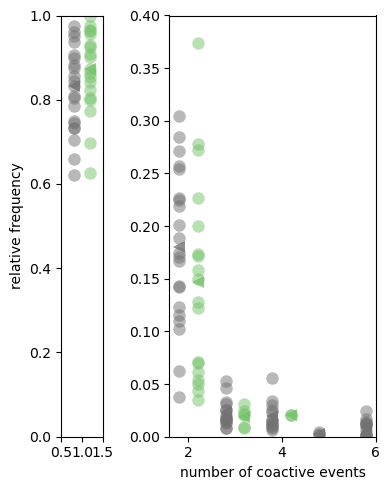

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      40
number of groups                  2
test statistic             2.226019
p-value                    0.131087
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.66602


In [22]:
rem_counts = collapse(rem_nrem_master['REM']['coactive_freqs'])
nrem_counts = collapse(rem_nrem_master['NREM']['coactive_freqs'])

colors = {"nrem": "#727272", "rem": "#74C269"}
offset = 0.2


# PLOT
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(4, 5),
    gridspec_kw={'width_ratios': [2, 10]}
)

# Left panel: coactive = 1 (median)
for counts, color, off in [
    (rem_counts, colors["rem"], offset),
    (nrem_counts, colors["nrem"], -offset)
]:
    plot_group(ax1, counts, ['1'], off, color, np.median)

ax1.set_xlim(0.5, 1.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel('relative frequency')


# Right panel: coactive >= 2 (mean)
keys = [str(i) for i in range(2, 7)]

for counts, color, off in [
    (rem_counts, colors["rem"], offset),
    (nrem_counts, colors["nrem"], -offset)
]:
    plot_group(ax2, counts, keys, off, color, np.mean)

ax2.set_xlabel('number of coactive events')
ax2.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()


# ============================================================
# STATS
# ============================================================
permanova_coactive_freqs(rem_nrem_master['NREM']['coactive_freqs'], rem_nrem_master['REM']['coactive_freqs'])



# figure H

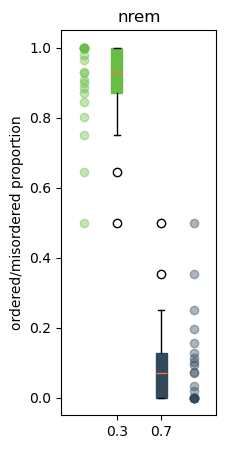

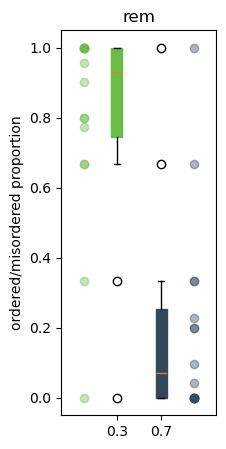

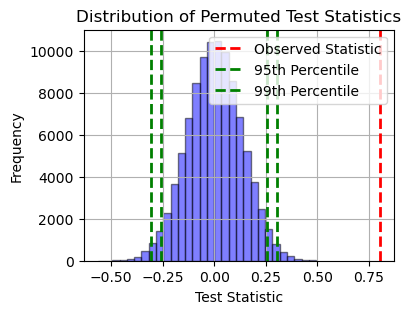

- p-value: 0.0
- 99th percentile of permuted statistics: 0.30406933612767395
- Observed Test Statistic: 0.8007120280365966
cohens d = 6.0230270340035545
------------------


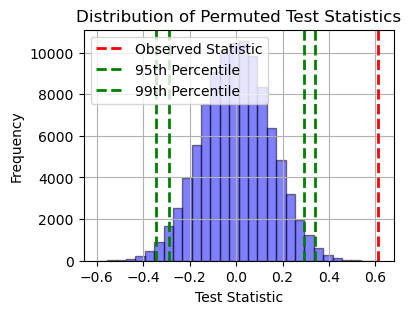

- p-value: 2e-05
- 99th percentile of permuted statistics: 0.34070342877341814
- Observed Test Statistic: 0.6122943378643273
cohens d = 2.1571918623983026
------------------
ShapiroResult(statistic=np.float64(0.7713919009228972), pvalue=np.float64(0.00024736257927586214))
ShapiroResult(statistic=np.float64(0.7713919009228979), pvalue=np.float64(0.00024736257927586756))
ShapiroResult(statistic=np.float64(0.7306490635159663), pvalue=np.float64(0.0003749818509315708))
ShapiroResult(statistic=np.float64(0.7306490635159655), pvalue=np.float64(0.0003749818509315636))
------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      37
number of groups                  2
test statistic             1.806033
p-value                       0.187
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.43973


In [12]:
# PLOT
plot_ordered_misrodered(rem_nrem_master['NREM']['ordered_misordered'],'nrem','ordered/misordered proportion')
plot_ordered_misrodered(rem_nrem_master['REM']['ordered_misordered'],'rem','ordered/misordered proportion')

# STATS
list1 = [float(item[0]) for item in rem_nrem_master['NREM']['ordered_misordered']] 
list2 = [float(item[1]) for item in rem_nrem_master['NREM']['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list3 = [float(item[0]) for item in rem_nrem_master['REM']['ordered_misordered']] 
list4 = [float(item[1]) for item in rem_nrem_master['REM']['ordered_misordered']] 
list3= [x for x in list3 if not np.isnan(x)] 
list4= [x for x in list4 if not np.isnan(x)] 
permutation_test(list3, list4)
print(f'cohens d = {cohens_d(list3, list4)}')

# test for normality
print('------------------')
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))
print(scipy.stats.shapiro(list3))
print(scipy.stats.shapiro(list4))
print('------------------')
# parmanova between groups
permanova_ordered_misordered(rem_nrem_master['NREM']['ordered_misordered'], rem_nrem_master['REM']['ordered_misordered'])


# figure I

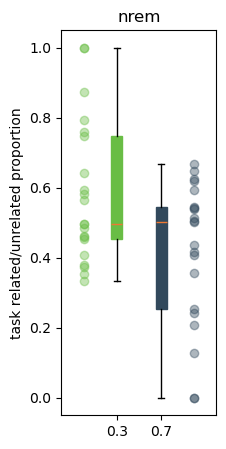

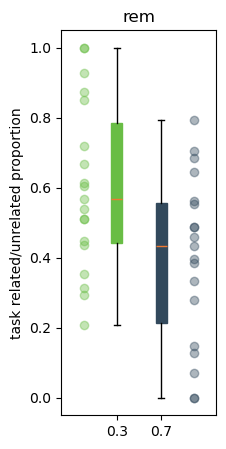

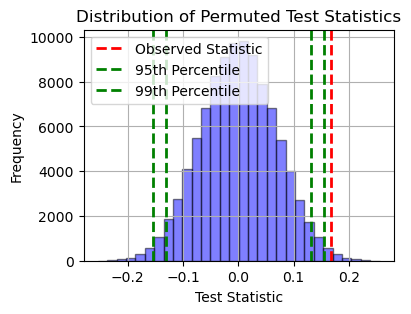

- p-value: 0.00587
- 99th percentile of permuted statistics: 0.15532464577089233
- Observed Test Statistic: 0.16722336566713547
cohens d = 0.8160469825472902
------------------


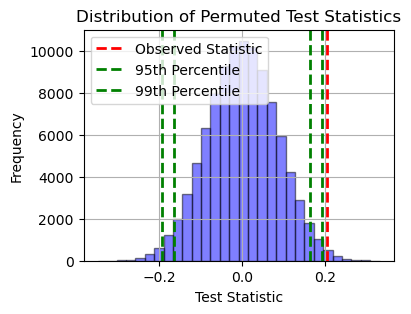

- p-value: 0.00646
- 99th percentile of permuted statistics: 0.19257284018727883
- Observed Test Statistic: 0.2044287749530917
cohens d = 0.8486081323892961
ShapiroResult(statistic=np.float64(0.9030756783902324), pvalue=np.float64(0.04015863072358345))
ShapiroResult(statistic=np.float64(0.9030756783902321), pvalue=np.float64(0.04015863072358291))
ShapiroResult(statistic=np.float64(0.9546064023612558), pvalue=np.float64(0.4714455919954149))
ShapiroResult(statistic=np.float64(0.9546064023612558), pvalue=np.float64(0.4714455919954149))
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      40
number of groups                  2
test statistic              0.06961
p-value                       0.795
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.62960


In [15]:
plot_ordered_misrodered(rem_nrem_master['NREM']['task_nontask'],'nrem','task related/unrelated proportion')
plot_ordered_misrodered(rem_nrem_master['REM']['task_nontask'],'rem','task related/unrelated proportion')

# STATS
list1 = [float(item[0]) for item in rem_nrem_master['NREM']['task_nontask']] 
list2 = [float(item[1]) for item in rem_nrem_master['NREM']['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list3 = [float(item[0]) for item in rem_nrem_master['REM']['task_nontask']] 
list4 = [float(item[1]) for item in rem_nrem_master['REM']['task_nontask']] 
list3= [x for x in list3 if not np.isnan(x)] 
list4= [x for x in list4 if not np.isnan(x)] 
permutation_test(list3, list4)
print(f'cohens d = {cohens_d(list3, list4)}')

# test for normality
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))
print(scipy.stats.shapiro(list3))
print(scipy.stats.shapiro(list4))

#permanova for nrem vs rem
permanova_ordered_misordered(rem_nrem_master['NREM']['task_nontask'], rem_nrem_master['REM']['task_nontask'])


# figure J

Fitted parameters: a = 0.03134361840164427, b = 3.2803097177615754
R-squared: 0.9953248403056675
p-values: [np.float64(3.7866195450320106e-06), np.float64(1.90887083917346e-09)]
Fitted parameters: a = 0.030106323906768415, b = 3.3211509550691662
R-squared: 0.9934043331802855
p-values: [np.float64(1.557158934106795e-05), np.float64(7.638629506701022e-09)]
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3579 2.0000 17.0000 15.2484 0.0002
         Pillai's trace 0.6421 2.0000 17.0000 15.2484 0.0002
 Hotelling-Lawley trace 1.7939 2.0000 17.0000 15.2484 0.0002
    Roy's greatest root 1.7939 2.0000 17.0000 15.2484 0.0002
------------------------------------------------------------
                                                   

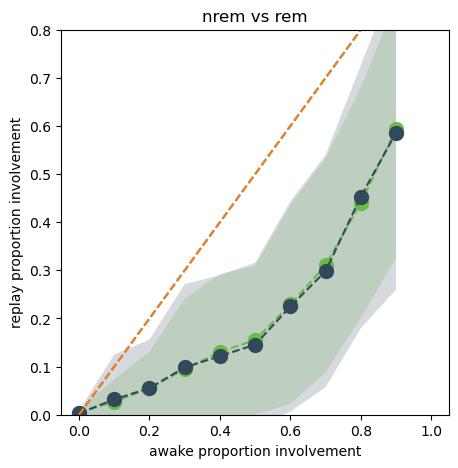

In [20]:
awake_seqbyseq_neuron_involvements = neuron_involvement_master['awake_seqbyseq_neuron_involvements']

fig, ax = plt.subplots(1, 1,figsize=(5, 5))
nrem_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,rem_nrem_master['NREM']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(nrem_awake_sleep_relationship,'#69BD45',ax)
rem_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,rem_nrem_master['REM']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(rem_awake_sleep_relationship,'#32495C',ax)
ax.set_title('nrem vs rem')

## STATS
m =manova_groups_neuron_involvement(nrem_awake_sleep_relationship,rem_awake_sleep_relationship)
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)


